# Pull Request Analysis

In [3]:
import psycopg2
import pandas as pd 
# from sqlalchemy.types import Integer, Text, String, DateTime
import sqlalchemy as s
import matplotlib
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import json

with open("config.json") as config_file:
    config = json.load(config_file)

database_connection_string = 'postgres+psycopg2://{}:{}@{}:{}/{}'.format(config['user'], config['password'], config['host'], config['port'], config['database'])

dbschema='augur_data'
engine = s.create_engine(
    database_connection_string,
    connect_args={'options': '-csearch_path={}'.format(dbschema)})

In [5]:
repo_id_list = pd.DataFrame()
myQuery = f"""
SELECT repo_group_id, repo_id, repo_name from repo;
    """
repo_id_list = pd.read_sql_query(myQuery, con=engine)
print(repo_id_list)

      repo_group_id  repo_id                           repo_name
0             25170    26687            distributed-tracing-demo
1             25170    26720        pa-services-execution-method
2             25179    27493  docs-boomi-atomsphere-int-services
3             25176    27178                    Out-Of-Queue-Bot
4             25177    27191        tcserver-spring-boot-samples
...             ...      ...                                 ...
2404          25171    26973                              fiscal
2405          25179    27274                                a11y
2406          25164    26130                philips-hue-resource
2407          25179    27399           pcf-bosh-terraforming-gcp
2408          25155    25541                rabbitmq-trust-store

[2409 rows x 3 columns]


## Pull Request Filter

In [2]:
## List of repository IDs for the report
repo_dict = {26214, 26215,26216, 26220, 26219, 25158, 26217, 26218}

## Weekly Complete Query and Visualization: Total Pull Requests Closed

Note: The intention is to replace this with an API call. 

Empty DataFrame
Columns: []
Index: []
26214
first time
26215
26216
25158
26217
26219
26220
26218


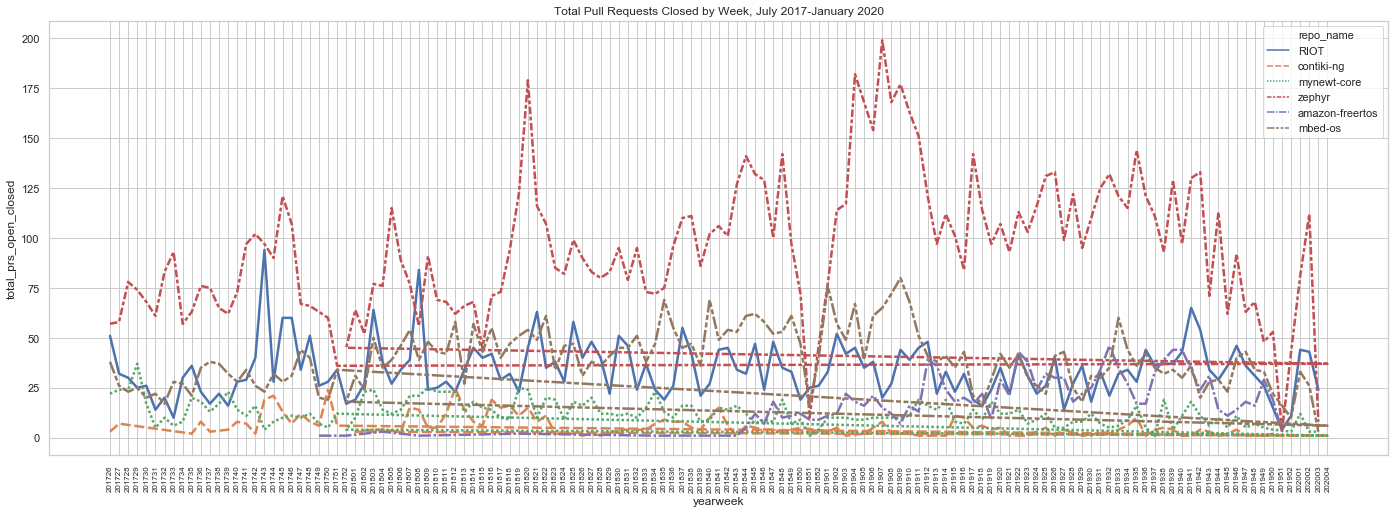

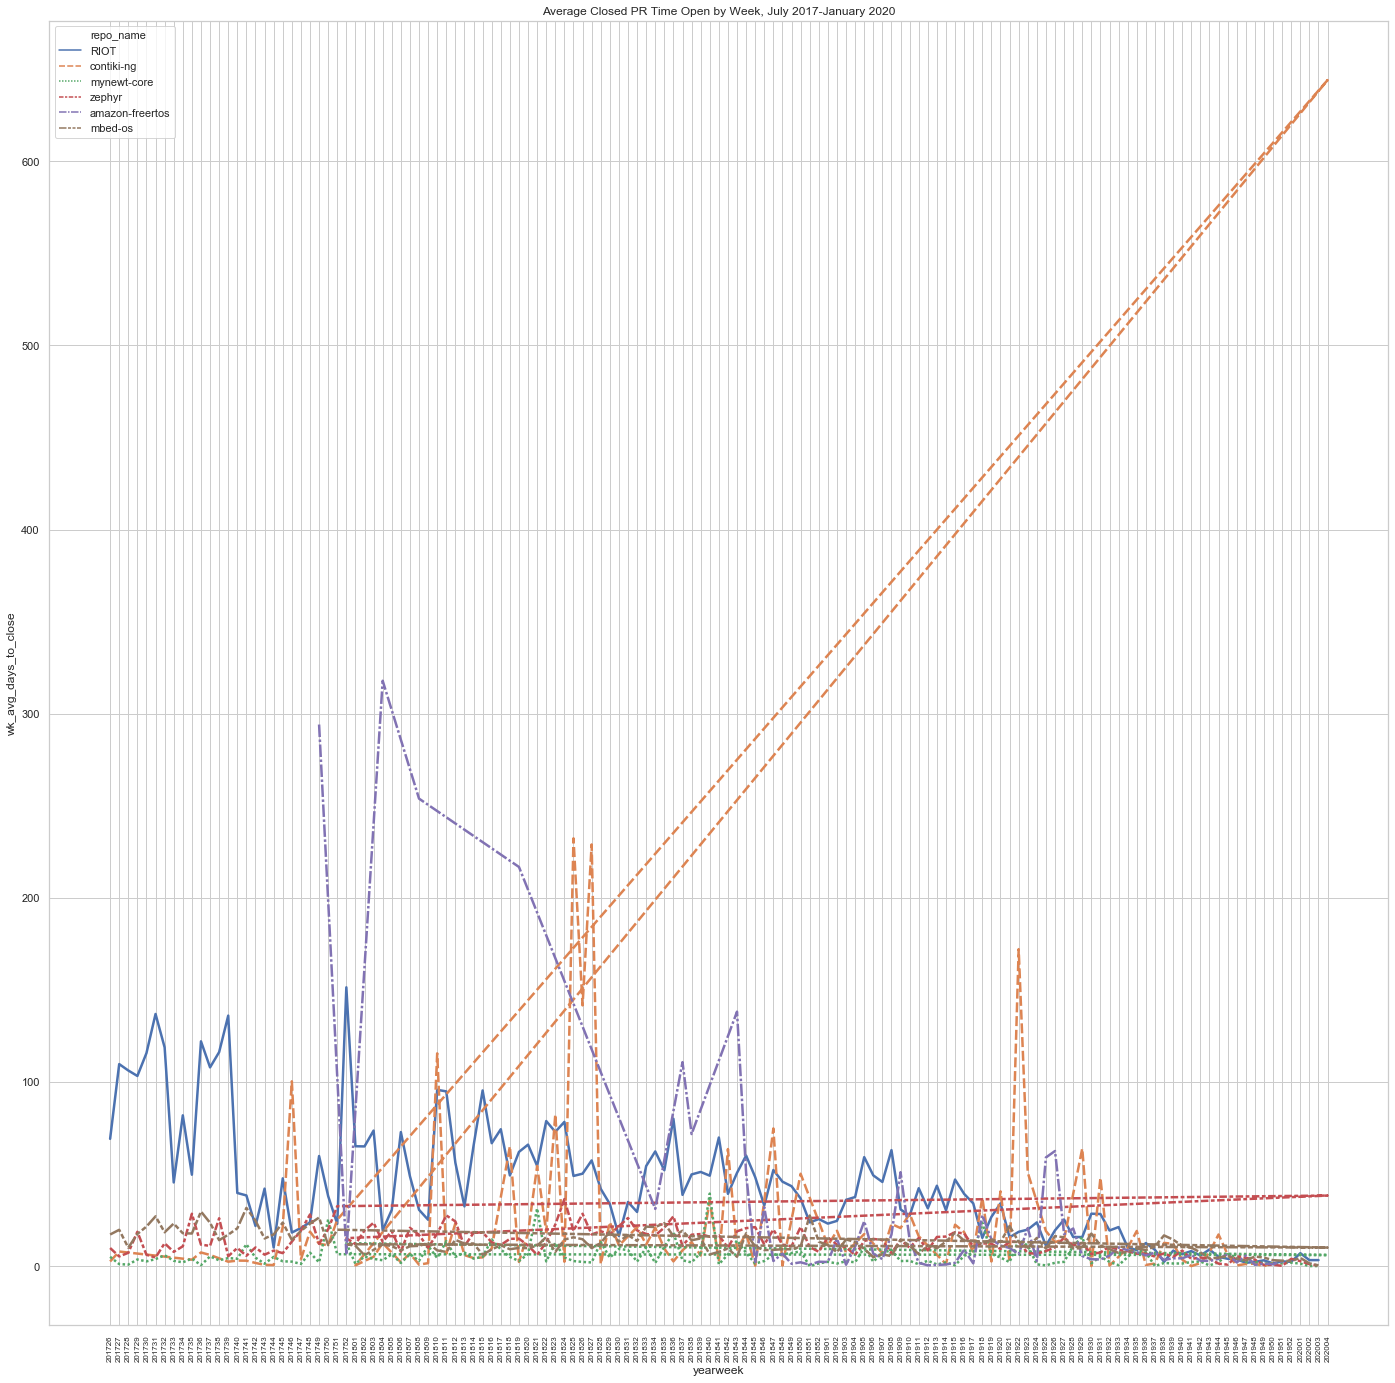

In [3]:
#Weekly Complete: Total Pull Requests Closed
sql_DF = pd.DataFrame()
print(sql_DF)
for value in repo_dict: 
    print(value)
#    sql_DFa = pd.read_sql
    myQuery = f"""
    SELECT 
        * 
        FROM  
            ( 
            SELECT 
                date_part( 'year', week :: DATE ) AS YEAR,
                date_part( 'week', week :: DATE ) AS week 
            FROM
                ( SELECT * FROM ( SELECT week :: DATE FROM generate_series ( TIMESTAMP '2017-07-01', TIMESTAMP '2020-01-30', INTERVAL '1 week' ) week ) d ) x 
            ) y
            LEFT OUTER JOIN (
            SELECT
                repo_id,
                repo_name,
                repo_group,
                date_part( 'year', pr_created_at :: DATE ) AS YEAR,
                date_part( 'week', pr_created_at :: DATE ) AS week,
                AVG ( hours_to_close ) AS wk_avg_hours_to_close,
                AVG ( days_to_close ) AS wk_avg_days_to_close,
                COUNT ( pr_src_id ) AS total_prs_open_closed 
            FROM
                (
                SELECT
                    repo.repo_id AS repo_id,
                    repo.repo_name AS repo_name,
                    repo_groups.rg_name AS repo_group,
                    pull_requests.pr_created_at AS pr_created_at,
                    pull_requests.pr_closed_at AS pr_closed_at,
                    pull_requests.pr_src_id AS pr_src_id,
                    ( EXTRACT ( EPOCH FROM pull_requests.pr_closed_at ) - EXTRACT ( EPOCH FROM pull_requests.pr_created_at ) ) / 3600 AS hours_to_close,
                    ( EXTRACT ( EPOCH FROM pull_requests.pr_closed_at ) - EXTRACT ( EPOCH FROM pull_requests.pr_created_at ) ) / 86400 AS days_to_close 
                FROM
                    repo,
                    repo_groups,
                    pull_requests 
                WHERE
                    repo.repo_group_id = repo_groups.repo_group_id 
                    AND repo.repo_id = pull_requests.repo_id 
                    AND repo.repo_id = {value} 
                    AND pull_requests.pr_src_state = 'closed' 
                ORDER BY
                    hours_to_close 
                ) L 
            GROUP BY
                L.repo_id,
                L.repo_name,
                L.repo_group,
                YEAR,
                week 
            ORDER BY
                repo_id,
                YEAR,
                week 
            ) T USING ( week, YEAR ) 
        ORDER BY
            YEAR,
            week;
        """
    sql_DFa = pd.read_sql_query(myQuery, con=engine)
    repo_id = value
    sql_DFa[['wk_avg_hours_to_close', 'wk_avg_days_to_close', 'total_prs_open_closed' ]] = sql_DFa[['wk_avg_hours_to_close', 'wk_avg_days_to_close', 'total_prs_open_closed' ]].fillna(value=0)
    sql_DFa[['repo_id']] = sql_DFa[['repo_id']].fillna(value=repo_id)
    if not sql_DF.empty: 
#        print(sql_DFa)
        sql_DF = pd.concat([sql_DF, sql_DFa]) 
#        print(sql_DF)
    else: 
        print('first time')
        sql_DF = sql_DFa
#        print(sql_DF)
        sql_DF.set_index('repo_id', 'year', 'week')
    
sql_DF.set_index('repo_id', 'year', 'week')
sql_DF['year'] = sql_DF['year'].map(int)
sql_DF['week'] = sql_DF['week'].map(int)
sql_DF['repo_id'] = sql_DF['repo_id'].map(int)
sql_DF['week'] = sql_DF['week'].map(lambda x: '{0:0>2}'.format(x))
sql_DF['yearweek'] = sql_DF['year'].map(str)+sql_DF['week'].map(str)
#sql_DF['yearweek'] = sql_DF['yearweek'].map(int)
sql_DF['week'] = sql_DF['week'].map(int)
sql_DF.set_index('repo_id', 'yearweek')
#print(sql_DF)
#sql_DF.dtypes
sns.set_style('ticks')
#sns.palplot(sns.color_palette('husl', 8))
#sns.set_palette('husl')
sns.set(style="whitegrid")

# Total PRS Closed
fig, ax = plt.subplots()
# the size of A4 paper
fig.set_size_inches(24, 8)
plotter = sns.lineplot(x='yearweek', y='total_prs_open_closed', style='repo_name', data=sql_DF, sort=False, legend='full', linewidth=2.5, hue='repo_name').set_title("Total Pull Requests Closed by Week, July 2017-January 2020")   
#ax.tick_params(axis='x', which='minor', labelsize='small', labelcolor='m', rotation=30)
plotterlabels = ax.set_xticklabels(sql_DF['yearweek'], rotation=90, fontsize=8)
fig.savefig('images/prs-zephyr-total-closed-wk.png')


#Average Days Open
fig, ax = plt.subplots()
# the size of A4 paper
fig.set_size_inches(24, 24)
plotter = sns.lineplot(x='yearweek', y='wk_avg_days_to_close', style='repo_name', data=sql_DF, sort=False, legend='full', linewidth=2.5, hue='repo_name').set_title("Average Closed PR Time Open by Week, July 2017-January 2020")   
#ax.tick_params(axis='x', which='minor', labelsize='small', labelcolor='m', rotation=30)
plotterlabels = ax.set_xticklabels(sql_DF['yearweek'], rotation=90, fontsize=8)
fig.savefig('images/prs-zephyr-average-open-time-wk.png')



## Monthly Complete Query and Visualization


Note: The intention is to replace this with an API call. 

Empty DataFrame
Columns: []
Index: []
26214
first time
26215
26216
25158
26217
26219
26220
26218


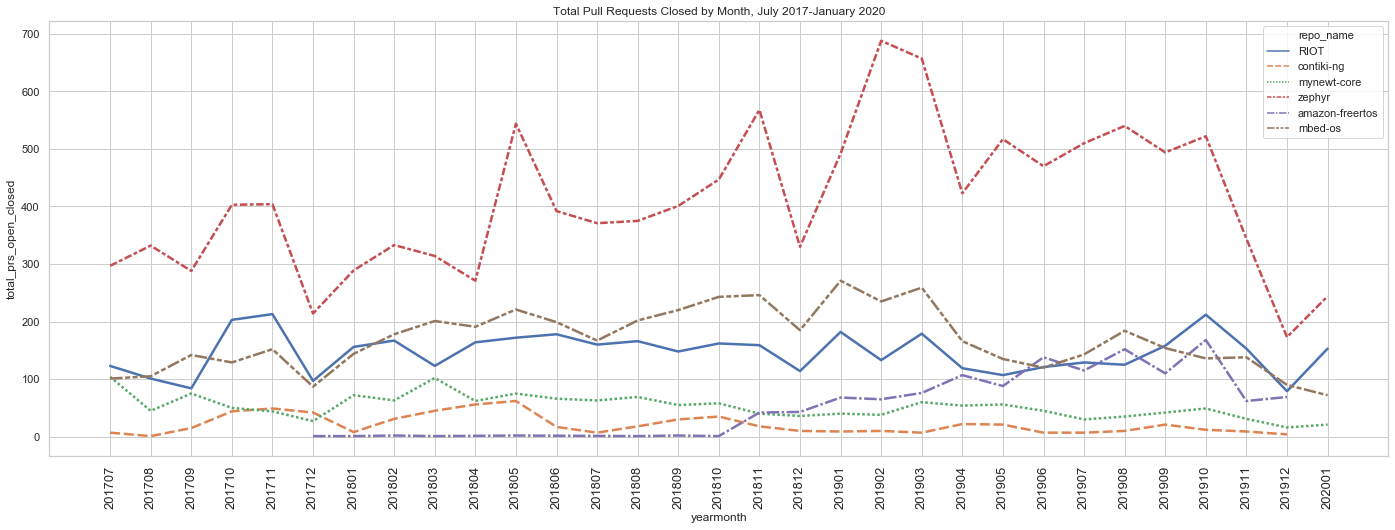

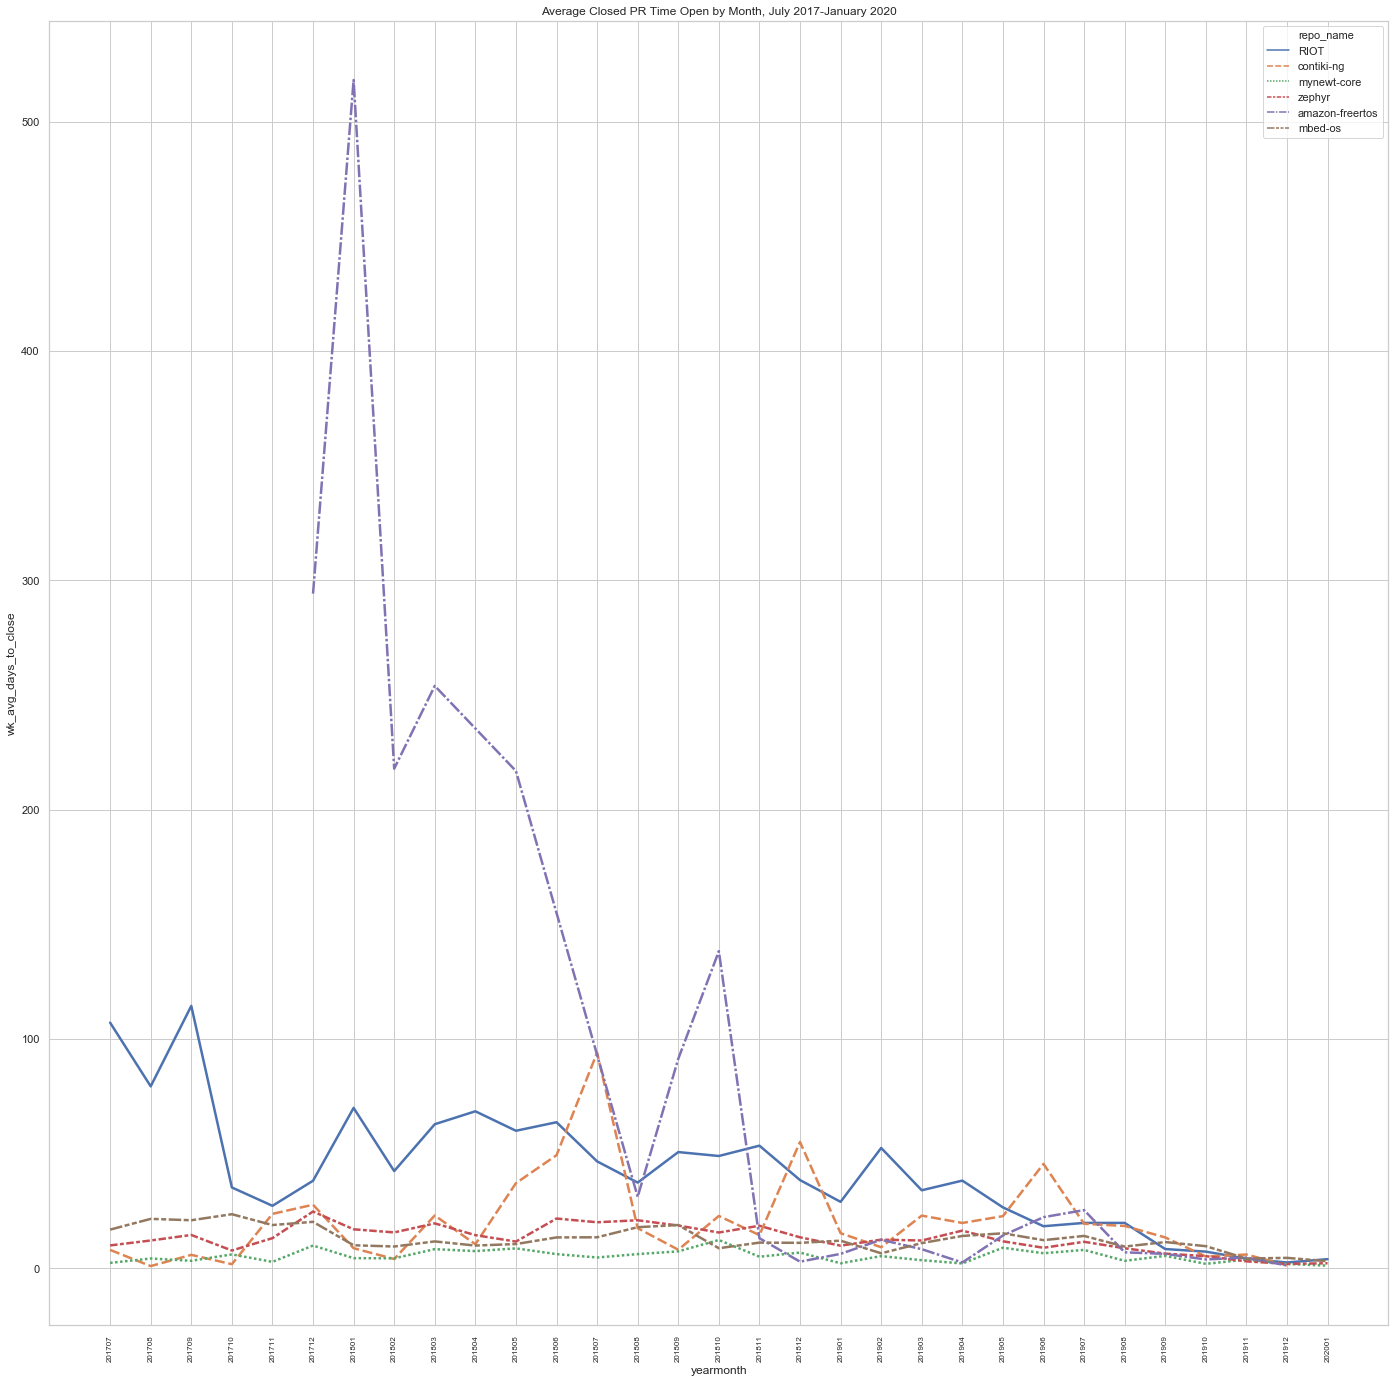

In [5]:
# Monthly Complete
pr_monthDF = pd.DataFrame()
print(pr_monthDF)
for value in repo_dict: 
    print(value)
#    sql_DFa = pd.read_sql
    pr_monthquery = f"""
                    SELECT
                        * 
                    FROM
                        (
                        SELECT
                            date_part( 'year', month :: DATE ) AS YEAR,
                            date_part( 'month', month :: DATE ) AS month 
                        FROM
                            ( SELECT * FROM ( SELECT month :: DATE FROM generate_series ( TIMESTAMP '2017-07-01', TIMESTAMP '2020-01-30', INTERVAL '1 month' ) month ) d ) x 
                        ) y
                        LEFT OUTER JOIN (
                        SELECT
                            repo_id,
                            repo_name,
                            repo_group,
                            date_part( 'year', pr_created_at :: DATE ) AS YEAR,
                            date_part( 'month', pr_created_at :: DATE ) AS month,
                            AVG ( hours_to_close ) AS wk_avg_hours_to_close,
                            AVG ( days_to_close ) AS wk_avg_days_to_close,
                            COUNT ( pr_src_id ) AS total_prs_open_closed 
                        FROM
                            (
                            SELECT
                                repo.repo_id AS repo_id,
                                repo.repo_name AS repo_name,
                                repo_groups.rg_name AS repo_group,
                                pull_requests.pr_created_at AS pr_created_at,
                                pull_requests.pr_closed_at AS pr_closed_at,
                                pull_requests.pr_src_id AS pr_src_id,
                                ( EXTRACT ( EPOCH FROM pull_requests.pr_closed_at ) - EXTRACT ( EPOCH FROM pull_requests.pr_created_at ) ) / 3600 AS hours_to_close,
                                ( EXTRACT ( EPOCH FROM pull_requests.pr_closed_at ) - EXTRACT ( EPOCH FROM pull_requests.pr_created_at ) ) / 86400 AS days_to_close 
                            FROM
                                repo,
                                repo_groups,
                                pull_requests 
                            WHERE
                                repo.repo_group_id = repo_groups.repo_group_id 
                                AND repo.repo_id = pull_requests.repo_id 
                                AND repo.repo_id = {value} 
                                AND pull_requests.pr_src_state = 'closed' 
                            ORDER BY
                                hours_to_close 
                            ) L 
                        GROUP BY
                            L.repo_id,
                            L.repo_name,
                            L.repo_group,
                            YEAR,
                            month 
                        ORDER BY
                            repo_id,
                            YEAR,
                            month 
                        ) T USING ( month, YEAR ) 
                    ORDER BY
                        YEAR,
                        month;

        """
    pr_monthDFa = pd.read_sql_query(pr_monthquery, con=engine)
    repo_id = value
    pr_monthDFa[['wk_avg_hours_to_close', 'wk_avg_days_to_close', 'total_prs_open_closed' ]] = pr_monthDFa[['wk_avg_hours_to_close', 'wk_avg_days_to_close', 'total_prs_open_closed' ]].fillna(value=0)
    pr_monthDFa[['repo_id']] = pr_monthDFa[['repo_id']].fillna(value=repo_id)
    if not pr_monthDF.empty: 
#        print(sql_DFa)
        pr_monthDF = pd.concat([pr_monthDF, pr_monthDFa]) 
#        print(sql_DF)
    else: 
        print('first time')
        pr_monthDF = pr_monthDFa
#        print(sql_DF)
        pr_monthDF.set_index('repo_id', 'year', 'month')


pr_monthDF.set_index('repo_id', 'year', 'month')

import matplotlib.pyplot as plt
pr_monthDF['year'] = pr_monthDF['year'].map(int)
pr_monthDF['month'] = pr_monthDF['month'].map(int)
pr_monthDF['repo_id'] = pr_monthDF['repo_id'].map(int)
pr_monthDF['month'] = pr_monthDF['month'].map(lambda x: '{0:0>2}'.format(x))
pr_monthDF['yearmonth'] = pr_monthDF['year'].map(str)+pr_monthDF['month'].map(str)
#sql_DF['yearweek'] = sql_DF['yearweek'].map(int)
pr_monthDF['month'] = pr_monthDF['month'].map(int)
pr_monthDF.set_index('repo_id', 'yearmonth')
#print(sql_DF)
#sql_DF.dtypes

sns.set_style('ticks')
#sns.palplot(sns.color_palette('husl', 8))
#sns.set_palette('husl')
sns.set(style="whitegrid")


#Total PRS open and closed by month
fig, ax = plt.subplots()
# the size of A4 paper
fig.set_size_inches(24, 8)
plottermonth = sns.lineplot(x='yearmonth', y='total_prs_open_closed', style='repo_name', data=pr_monthDF, sort=False, legend='full', linewidth=2.5, hue='repo_name').set_title("Total Pull Requests Closed by Month, July 2017-January 2020")   
#ax.tick_params(axis='x', which='minor', labelsize='small', labelcolor='m', rotation=30)
plottermonthlabels = ax.set_xticklabels(pr_monthDF['yearmonth'], rotation=90, fontsize=13)
fig.savefig('images/prs-zephyr-monthly-total-open-closed.png')


#Average Days Open by Month
fig, ax = plt.subplots()
# the size of A4 paper
fig.set_size_inches(24, 24)
plottermonth = sns.lineplot(x='yearmonth', y='wk_avg_days_to_close', style='repo_name', data=pr_monthDF, sort=False, legend='full', linewidth=2.5, hue='repo_name').set_title("Average Closed PR Time Open by Month, July 2017-January 2020")   
#ax.tick_params(axis='x', which='minor', labelsize='small', labelcolor='m', rotation=30)
plotterlabels = ax.set_xticklabels(pr_monthDF['yearmonth'], rotation=90, fontsize=8)
fig.savefig('images/prs-zephyr-average-open-time-month.png')



